# PyTorch Workflow


1. data (Prepare and load)
2. build model
3. fitting the model to the data (training)
4. making prediction and evaluating model (inference)
5. saving and loading a model
6. putting it all together


In [96]:
import torch
from torch import nn # nn contains all the pytorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

# Check PyTorch version
torch.__version__

'2.5.1+cu124'

## 1. Data (Preparing and Loading)

In [97]:
# linear regression to create some data

weight = 0.7
bias = 0.3

# Create 
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 

X[:10], y[:10], len(X), len(y)


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [98]:
# Splitting data training and testing data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(train_data,
                     train_labels,
                     test_data,
                     test_labels,
                     predictions=None):
    """
    Plots training data, test data, and optionally predictions.
    
    Args:
    - train_data: Training data (X_train).
    - train_labels: Labels corresponding to train_data (y_train).
    - test_data: Testing data (X_test).
    - test_labels: Labels corresponding to test_data (y_test).
    - predictions: Optional. Model predictions on the test_data.
    """
    plt.figure(figsize=(10, 7))
    
    # Plot training data
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    
    # Plot testing data
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")
    
    # Plot predictions if provided
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    # Add legend
    plt.legend(prop={"size": 14})
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title("Training, Testing Data and Predictions")
    plt.show()


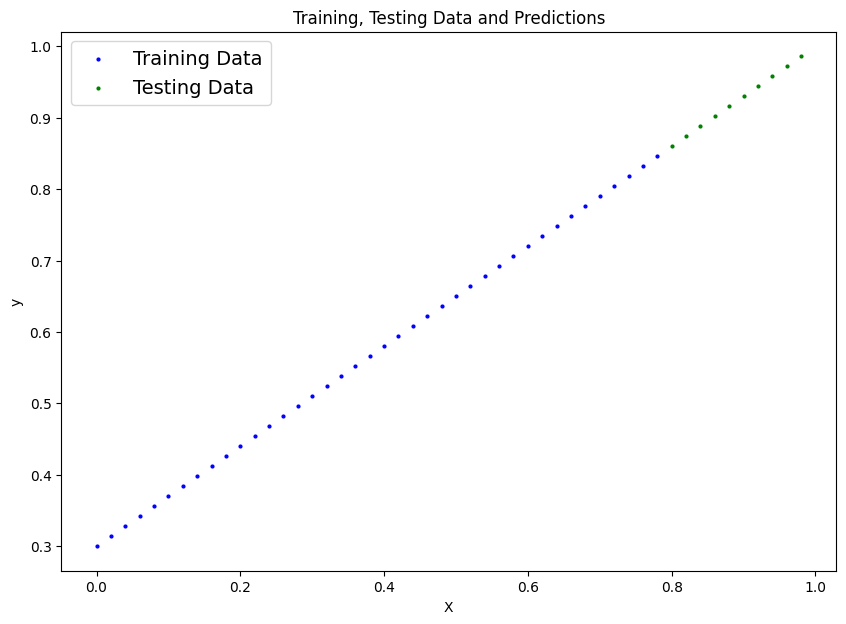

In [100]:
X_train_np = X_train.tolist()
y_train_np = y_train.tolist()
X_test_np = X_test.tolist()
y_test_np = y_test.tolist()

# Fake predictions for testing
# predictions = y_test_np + 0.05  # Add small offset as dummy predictions

# Call the function
plot_predictions(train_data=X_train_np,
                 train_labels=y_train_np,
                 test_data=X_test_np,
                 test_labels=y_test_np,)

## 2. Build Pytorch Model

In [101]:
# Create LinearRegression Model Class

class LinearRegressionModel(nn.Module):# <-nn.Module is like lego building bricks for pytorch model
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                               requires_grad=True,
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
    
    # Forward method to define the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights*x + self.bias # this is the linear regression formula 





In [102]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [103]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using 'torch.inference_mode()'

In [104]:
# Make prediction with model
with torch.inference_mode():
    y_preds = model_0(X_test)
 
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

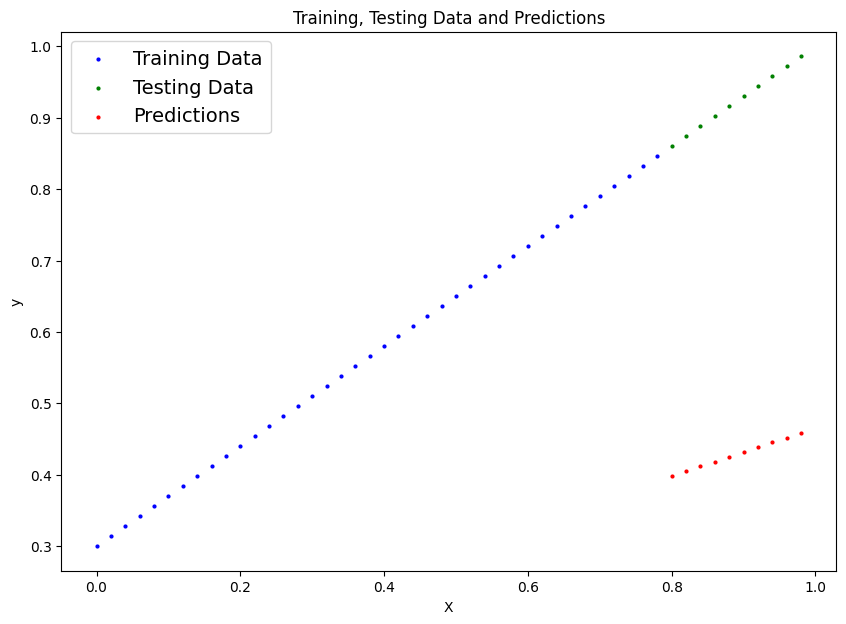

In [105]:
X_train_np = X_train.tolist()
y_train_np = y_train.tolist()
X_test_np = X_test.tolist()
y_test_np = y_test.tolist()

# Fake predictions for testing
# predictions = y_test_np + 0.05  # Add small offset as dummy predictions

# Call the function
plot_predictions(train_data=X_train_np,
                 train_labels=y_train_np,
                test_data=X_test_np,
                 test_labels=y_test_np,
                 predictions=y_preds.tolist())

## 3. Train Model
Things we need to train:
* Loss Function - Measures how wrong our model's predictions are to the ideal output
* Optimizer - Takes into account the loss and adjust the parameters accordingly

In [106]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [107]:
# Check out our model's parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [108]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01) # learning rate = hyperparameter which we set

### Building a training loop in pytorch

In [109]:
# An epoch is one iteration of complete data
torch.manual_seed(42)

epochs = 200

epoch_count = []
test_loss_values = []
loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # train mode in pytorch set grad = True

    # 1. Forward Pass
    y_preds = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_preds,y_train)
    # print(f"Loss: {loss}")

    # 3. Optimizer Zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer(perfomr gradient descent)
    optimizer.step() 

    ### Testing
    model_0.eval() # turns off different settings in model which are not reqired for evaluation
    with torch.inference_mode(): # turns off gradient tracking
        # 1. Do the foward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred,y_test) 
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())


Epoch: 0 | loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

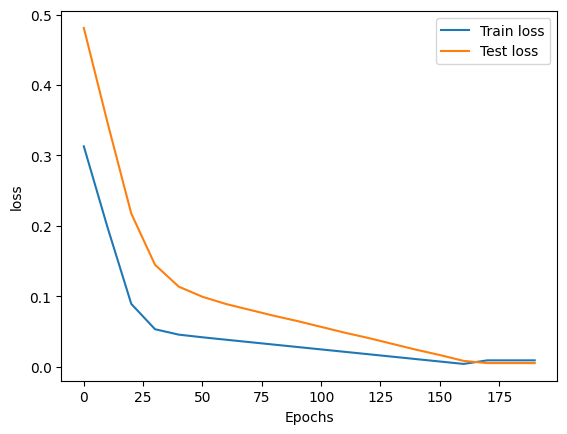

In [115]:
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Train loss")
plt.plot(epoch_count, np.array(test_loss_values), label="Test loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()

In [111]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

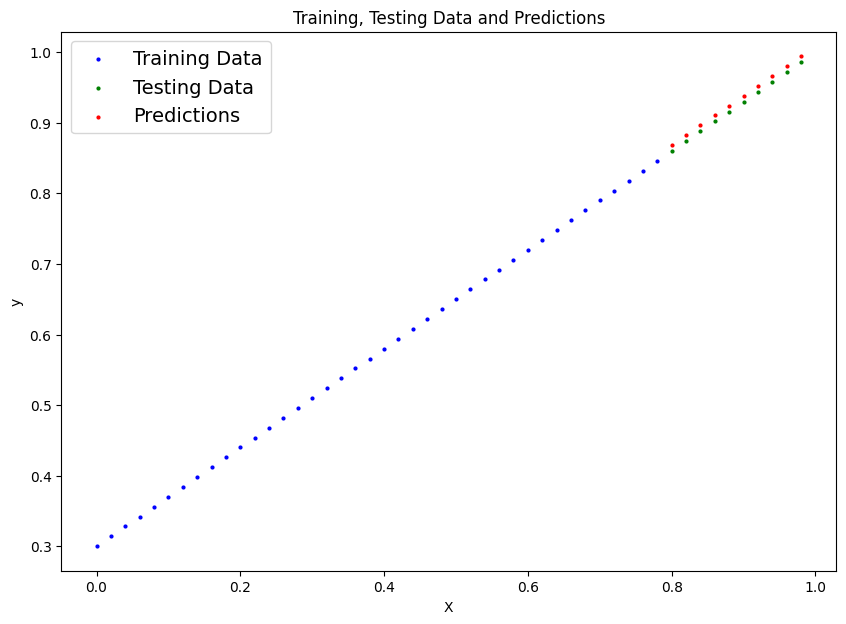

In [112]:
X_train_np = X_train.tolist()
y_train_np = y_train.tolist()
X_test_np = X_test.tolist()
y_test_np = y_test.tolist()

# Fake predictions for testing
# predictions = y_test_np + 0.05  # Add small offset as dummy predictions

# Call the function
plot_predictions(train_data=X_train_np,
                 train_labels=y_train_np,
                test_data=X_test_np,
                 test_labels=y_test_np,
                 predictions=y_preds_new.tolist())

In [113]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [114]:
weight, bias

(0.7, 0.3)

## Saing a model in Pytorch

Three Methords:
1. torch.save() -> allows you to save in python pickle format
2. torch.load() -> allows you to load a saved pytorch object
3. torch.nn.Module.load_state_dict() -> this allows to load a model's saved state dictionary

In [117]:
# Saving our Pytorch model
from pathlib import Path 
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. model save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a Pytorch model

Since we saved our model's 'state_dict()' rather than the entire model, we'll create a new instance of our model class and load the saved 'state_dict()' into that.

In [118]:
# to load in saved state_dict we have to instantiate a new instance of our model class

loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

/tmp/ipykernel_390609/2103311783.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [119]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [120]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [123]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
    

In [124]:
# Compare loaded model preds with original model preds 
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])